In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt
import scipy as sc

In [1]:
import sys
import numpy as np
import lbg_forecast.population_model as pop
import lbg_forecast.priors_gp_massfunc as gpmf
import lbg_forecast.priors_gp_dust as gpdp
import lbg_forecast.priors_gp_csfrd as gpsf


print("Loading Priors ... ", flush=True)
mass_function_prior = gpmf.MassFunctionPrior()
dust_prior = gpdp.DustPrior()
csfrd_prior = gpsf.CSFRDPrior()

Loading Priors ... 
Loading Models
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over z
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_map

In [4]:
nrealisations=2
ngals=100000

print("Begin Sampling ... ", flush=True)

spsp = []
for n in range(nrealisations):
    sps_params = pop.generate_sps_parameters(ngals, mass_function_prior, dust_prior, csfrd_prior)
    spsp.append(sps_params)
    print("Realisation: ", n+1, flush=True)

spsp = np.array(spsp)

Begin Sampling ... 


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:153: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


: 

In [ ]:
nzs = []
for n in range(sps_parameters.shape[0]):    
    lbg_nzs = nz.simulate_nzs(sps_parameters[n, :, :], model, batch_size)
    nzs.append(lbg_nzs)
    print("Realisation: ", n+1, flush=True)

In [3]:
spsp = np.load("sps_parameter_samples/sps_0.npy")
nzs = np.load("nz_samples/nz_0.npy", allow_pickle=True)
print(spsp.shape,  nzs.shape)

(8, 10000, 17) (8, 3)


TypeError: len() of unsized object

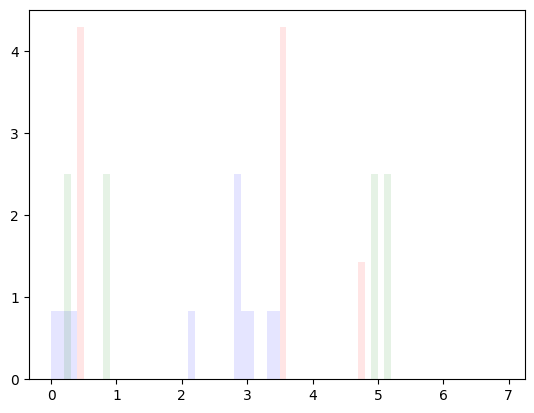

In [4]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

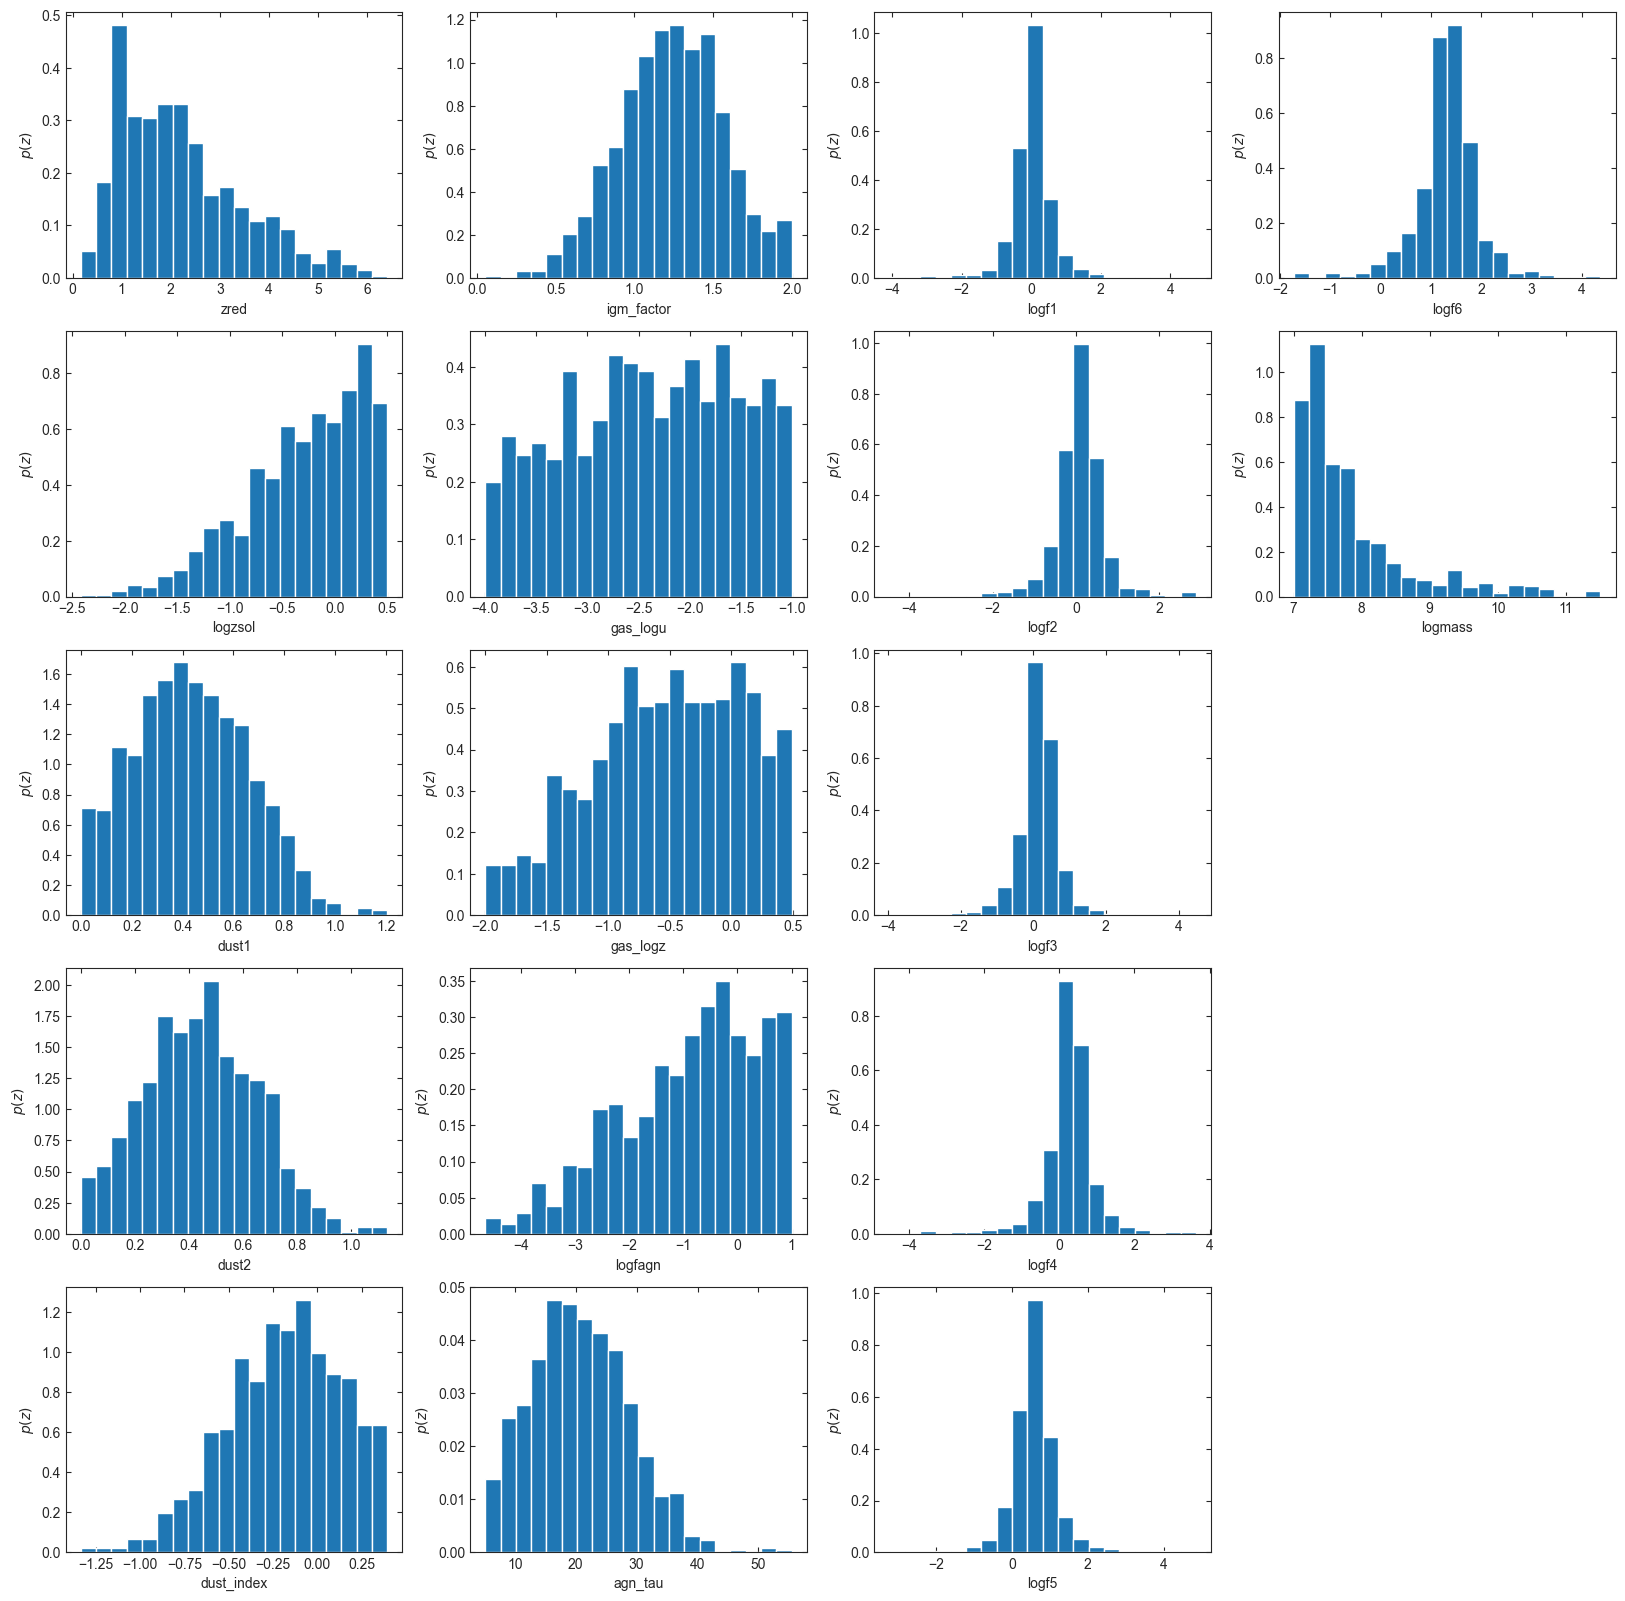

In [3]:
indx=0
pop.plot_galaxy_population(spsp[indx])

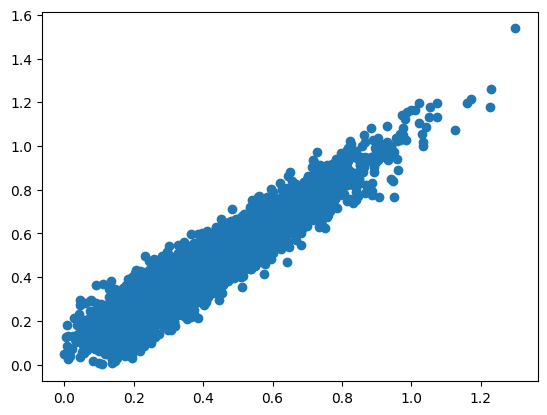

In [20]:
indx=3
plt.scatter(spsp[indx][:, 3], spsp[indx][:, 2])

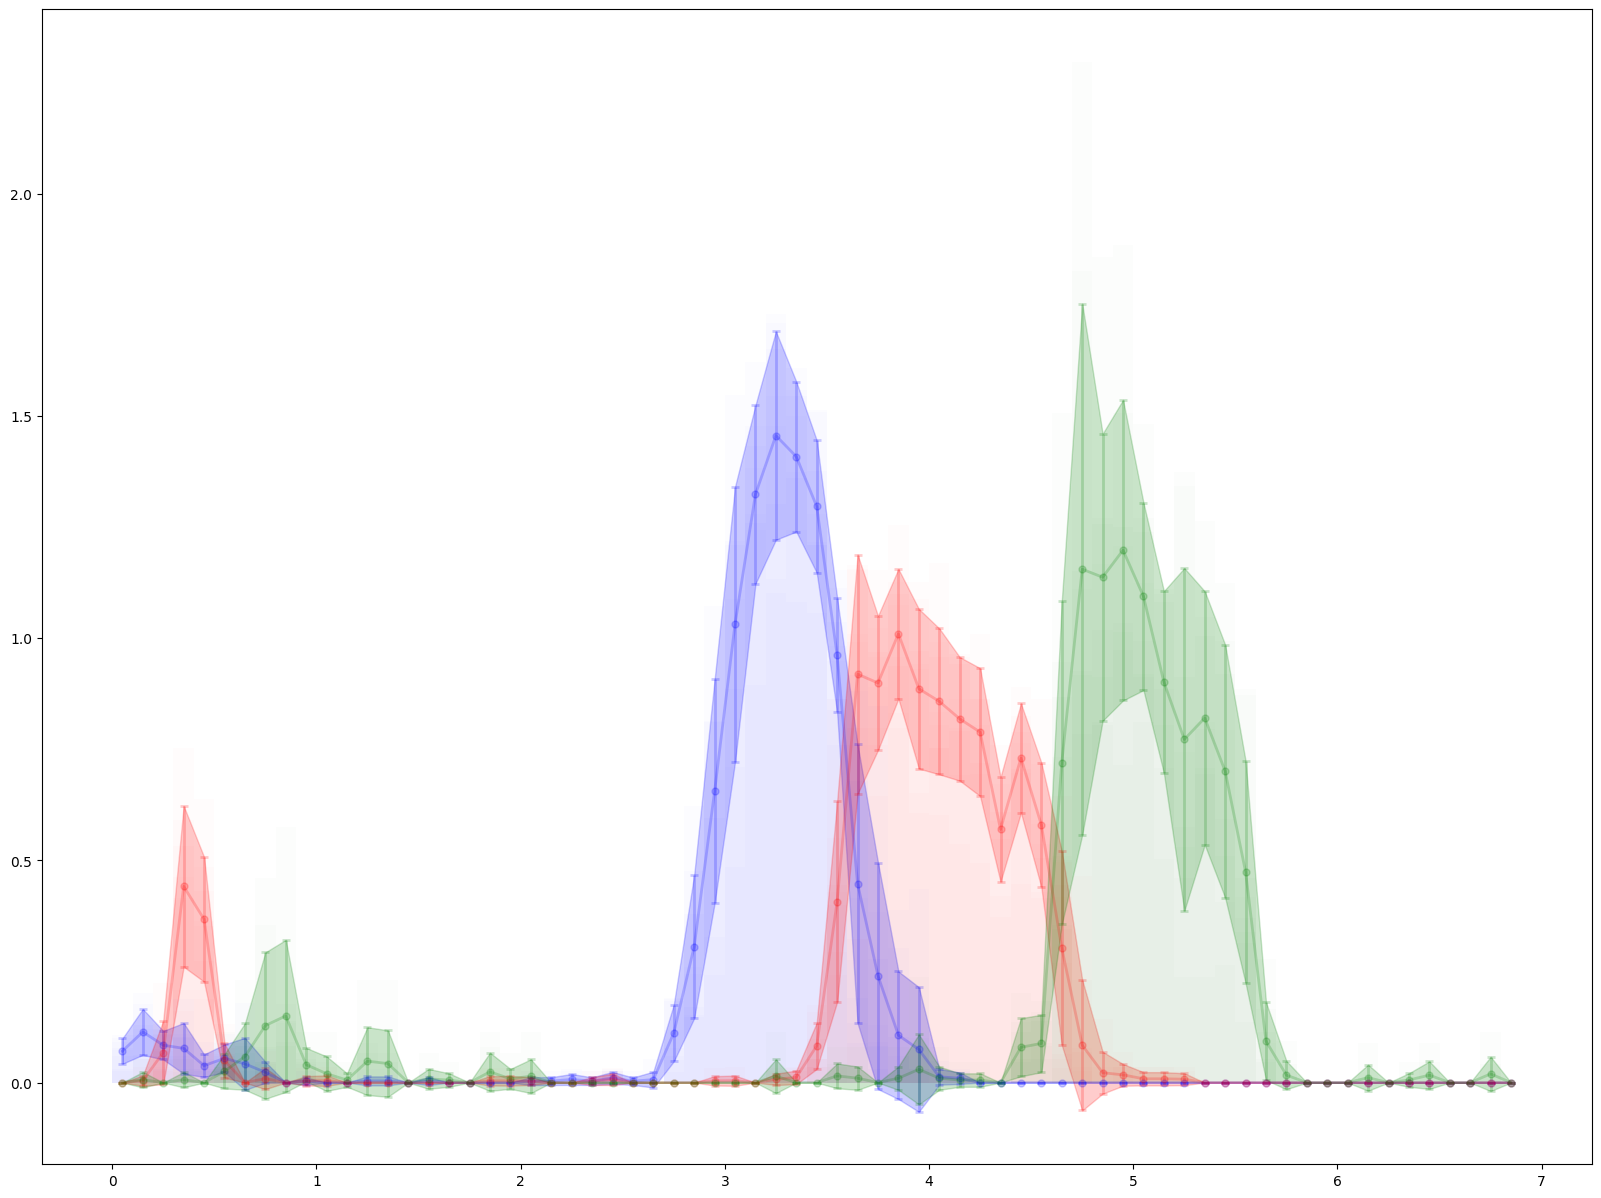

In [5]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nzs.shape[0]):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

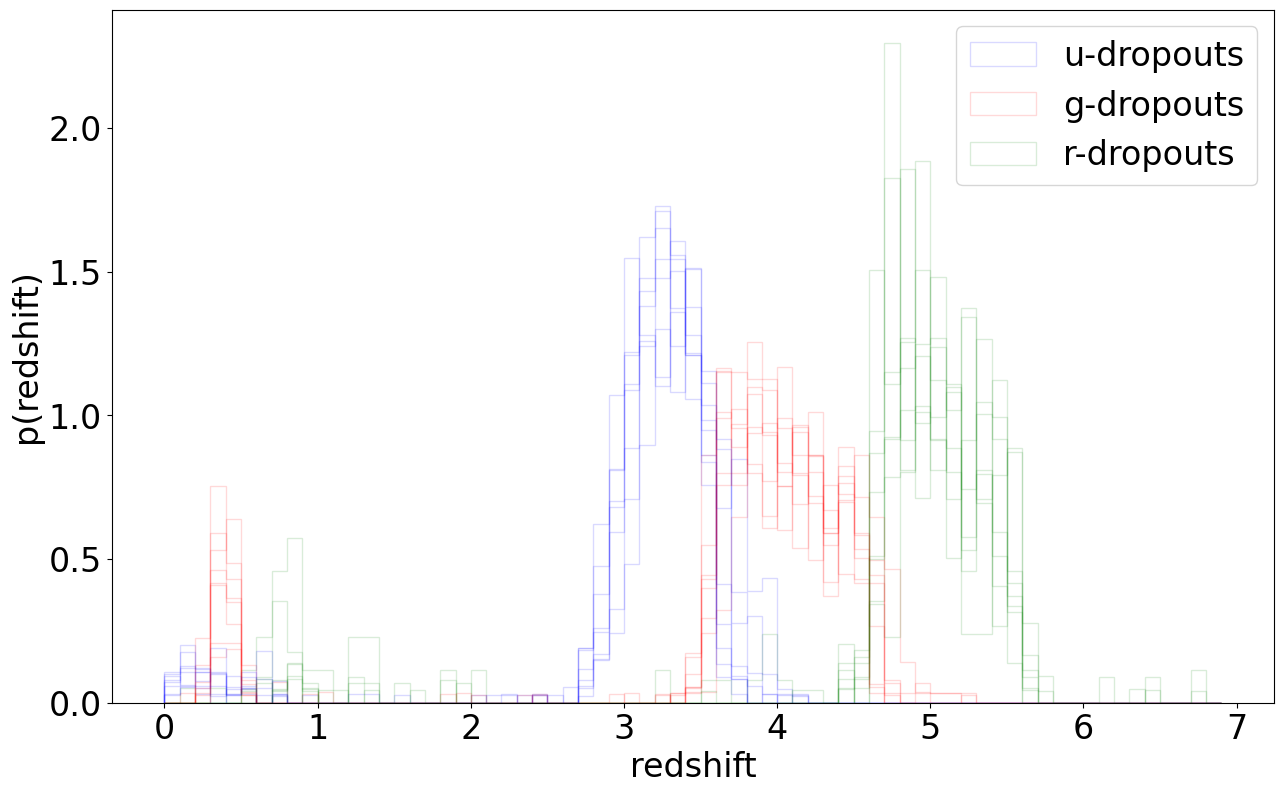

In [6]:
colours = ['blue', 'red', 'green']
labels = ['u-dropouts', "g-dropouts", "r-dropouts"]
ndropouts=3
f, ax = plt.subplots(1, 1, figsize=(15, 9))
for ind in range(nzs.shape[0]):
    for drop in range(ndropouts):
        if(ind == 0):
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step', label=labels[drop])
        else:
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step')
plt.legend(fontsize=24)
plt.xlabel("redshift", fontsize=24)
plt.ylabel("p(redshift)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)

(0.0, 2.5)

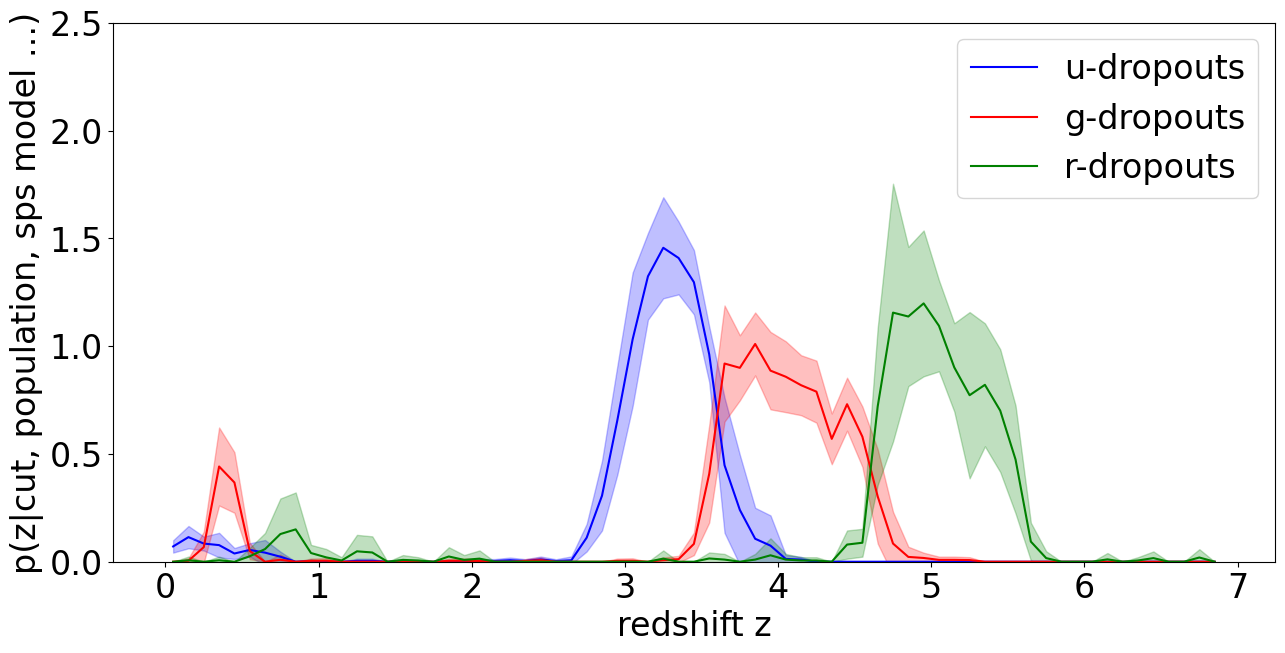

In [7]:
fig1, axes = plt.subplots(1, 1, figsize=(15,7), sharex=False, sharey=False)

for drop in range(ndropouts):

    values = []
    x = []
    for ind in range(nzs.shape[0]):
        hist = axes.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=nz.default_nz_bins())
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=nz.default_nz_bins())
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    #axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=10, fmt="o", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop], label=labels[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.25, color=colours[drop])
    axes.plot(bin_centers, bin_means, color=colours[drop], label=labels[drop])

plt.legend(fontsize=24)
plt.xlabel("redshift z", fontsize=24)
plt.ylabel("p(z|cut, population, sps model ...)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)
plt.ylim(0, 2.5)

In [8]:
#np.save("nzs_test4.npy", nzs)
#np.save("spsp_test4.npy", spsp)